In [1]:
import os
import numpy as np
import pandas as pd

raw_data = pd.read_csv("../input/rows.csv",
                      usecols=["CMPLNT_FR_DT", "Latitude", "Longitude"]).dropna()

# Data is supposed to start 2006-01-01, filter previous dates
day_one = np.datetime64('2006-01-01')
days = (pd.to_datetime(raw_data['CMPLNT_FR_DT'], 
                 format='%m/%d/%Y', errors='coerce') - day_one).dt.days
days = days[days.isnull() == False]
days = days[days > 0]

# Filter outliers
rd = raw_data
rd = rd[rd['Latitude'] > rd['Latitude'].mean() - 3 * rd['Latitude'].std()]\
                [rd['Latitude'] < rd['Latitude'].mean() + 3 * rd['Latitude'].std()]
rd = rd[rd['Longitude'] > rd['Longitude'].mean() - 3 * rd['Longitude'].std()]\
                [rd['Longitude'] < rd['Longitude'].mean() + 3 * rd['Longitude'].std()]

# Discretize latitude and longitude
min_lat, max_lat = min(rd["Latitude"]), max(rd["Latitude"])
min_lng, max_lng = min(rd["Longitude"]), max(rd["Longitude"])
GRID_LNG_DIM = 100
GRID_LAT_DIM = 120
lng_step = (max_lng - min_lng) / (GRID_LNG_DIM - 1)
lat_step = (max_lat - min_lat) / (GRID_LAT_DIM - 1)
def to_grid_lat(lat):
    return (lat - min_lat) // lat_step
def to_grid_lng(lng):
    return (lng - min_lng) // lng_step

# Create final dataset
data = pd.DataFrame(rd["CMPLNT_FR_DT"])
data["Days"] = days
data["GridLat"] = to_grid_lat(rd['Latitude'])
data["GridLng"] = to_grid_lng(rd['Longitude'])
data = data.dropna()
data["Days"] = data["Days"].astype("int16")
data["GridLat"] = data["GridLat"].astype("int8")
data["GridLng"] = data["GridLng"].astype("int8")
# To split the validation set to the most recent crimes
data.sort_values(by=["Days"])



# We create a (4748, 101, 121) boolean array to track if in a specific day and place there was a crime
crime_grid = np.zeros((max(data["Days"]) + 1, GRID_LNG_DIM + 1, GRID_LAT_DIM + 1), dtype="bool")
crime_grid[data["Days"], data["GridLng"], data["GridLat"]] = True

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [2]:
index = np.arange(1,31)[None, :] + np.arange(4718)[:, None]
x = crime_grid[index]
X = x[:, :29, :, :, None]
y = x[:, 29, :, :, None]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [3]:
X_train.shape

(3774, 29, 101, 121, 1)

In [4]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model


model = Sequential()
model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='tanh', recurrent_activation='hard_sigmoid', 
                        kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                        kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                        return_sequences=False,
                        padding='same',
                        data_format='channels_last',
                        dropout=0.0, recurrent_dropout=0.0))

model.compile(optimizer=Adam(decay=1e-4),
              loss='mean_squared_error',
              metrics=['accuracy'])

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'crime_prediction.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

model.fit(X_train, y_train,
          batch_size=120,
          epochs=20,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Train on 3774 samples, validate on 944 samples
Epoch 1/20
3774/3774 [==============================] - 25s 7ms/step - loss: 0.0880 - acc: 0.9247 - val_loss: 0.0735 - val_acc: 0.9250

Epoch 00001: val_acc improved from -inf to 0.92498, saving model to /kaggle/working/saved_models/crime_prediction.001.h5
Epoch 2/20
3774/3774 [==============================] - 19s 5ms/step - loss: 0.0703 - acc: 0.9249 - val_loss: 0.0676 - val_acc: 0.9250

Epoch 00002: val_acc improved from 0.92498 to 0.92498, saving model to /kaggle/working/saved_models/crime_prediction.002.h5
Epoch 3/20
3774/3774 [==============================] - 19s 5ms/step - loss: 0.0660 - acc: 0.9249 - val_loss: 0.0644 - val_acc: 0.9250

Epoch 00003: val_acc did not improve from 0.92498
Epoch 4/20
3774/3774 [==============================] - 19s 5ms/step - loss: 0.0634 - acc: 0.9249 - val_loss: 0.0623 - val_acc: 0.9250

Epoch 00004: val_acc did not improve from 0.92498
Epoch 5/20
3774/3774 [==============================] - 19s 5ms/

In [5]:
y_test[0][:,:,0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

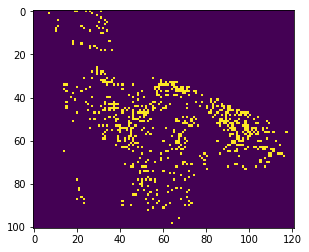

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

r = y_test[0][:,:,0]
p = np.round(model.predict(X_test[:2]), decimals=0)[0][:, :, 0]

plt.imshow(r)

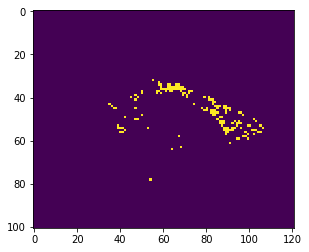

In [7]:
plt.imshow(p)

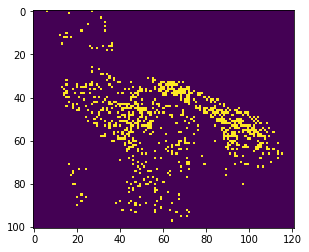

In [8]:
r110 = y_test[110][:, :, 0]
p110 = np.round(model.predict(X_test[:900]), decimals=0)[110][:, :, 0]

plt.imshow(r110)

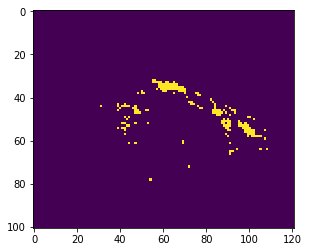

In [9]:
plt.imshow(p110)